In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mpmath

from scipy import special
from tqdm import tqdm
from typing import List, Tuple


In [ ]:
####### copied methods from the original code #######
def compute_asymptotic_power(method: int, theta_arr: List[float], c_arr: List[float]) -> float:
    """For one of the four methods, compute the asymptotic power.

    Args:
        method (int): {0: 'unweighted_stacksvd', 1: 'weighted_stacksvd', 2: 'unweighted_svdstack', 3: 'weighted_svdstack'}
        theta_arr (List[float]): Length M array of signal strengths
        c_arr (List[float]): Length M array of ratios n_i / d for each matrix

    Returns:
        float: Asymptotic power of the method
    """
    M = len(c_arr)
    c_arr = np.array(c_arr).astype(float)
    theta_arr = np.array(theta_arr).astype(float)
    theta_norm_sq = np.linalg.norm(theta_arr)**2
    
    if method == 0:  # unweighted stack-svd
        return max((theta_norm_sq**2 - c_arr.sum()) / (theta_norm_sq * (theta_norm_sq + 1)),0)
    
    if method == 1:  # weighted stack-svd
        theta_red = theta_arr[theta_arr > 0]
        c_red = c_arr[theta_arr > 0]
        def f(x):
            return sum(theta**2 * (1 - x) / (c*theta**-2 + x) for theta, c in zip(theta_red, c_red)) - 1
        
        # Binary search for the unique solution x in (0, 1)
        low, high = 0, 1
        while high - low > 1e-7:
            mid = (low + high) / 2
            if f(mid) > 0:
                low = mid
            else:
                high = mid
        x = (low + high) / 2
        return x
    
    denom = theta_arr**4 + theta_arr**2
    inv_denom = np.ones(M)
    # print(denom, type(denom), denom.shape)
    inv_denom[denom > 0] = 1 / denom[denom > 0]
    beta_vec = np.sqrt(np.maximum((theta_arr**4 - c_arr) * inv_denom, 0))
    # beta_vec = np.sqrt(np.maximum((theta_arr**4 - c_arr) / (theta_arr**4 + theta_arr**2), 0))
    if method == 2: # unweighted svd-stack    
        A = np.outer(beta_vec,beta_vec) + np.diag(1 - beta_vec**2)
        eigenvalues, eigenvectors = np.linalg.eigh(A)
        idx = np.argmax(np.abs(eigenvalues))
        lam = eigenvalues[idx]

        ####### old version with eigenvec
        principal_eigenvector = eigenvectors[:, idx]
        num = (principal_eigenvector @ beta_vec)**2
        # denom = 1 + (principal_eigenvector@ beta_vec)**2 - ((principal_eigenvector * beta_vec)**2).sum()
        denom = lam
        return num / denom
    if method == 3: # weighted svd-stack
        S = np.sum(beta_vec**2 / (1 - beta_vec**2))
        return S / (S+1)
    
    raise ValueError("Invalid method number")


def generate_data(d: int, c_arr: List[float], theta_arr: List[float]) -> Tuple[List[np.ndarray], np.ndarray]:
    """
    Generate synthetic data according to the model X_i = theta_i * u_i * v^T + E_i
    
    Args:
        d: Column dimension (shared across matrices)
        c_arr: List of ratios n_i / d for each matrix
        theta_arr: List of signal strengths
        
    Returns:
        X_list: List of generated matrices
        v: True shared component
    """
    M = len(c_arr)
    assert len(theta_arr) == M, "theta_arr must have same length as c_arr"
    
    assert all(c > 0 for c in c_arr), "All elements of c_arr must be positive"
    
    # Generate true v
    v = np.random.normal(size=d)
    v /= np.linalg.norm(v)
    
    X_list = []
    for i in range(M):
        n_i = int(c_arr[i] * d)
        u_i = np.random.normal(size=n_i)
        u_i /= np.linalg.norm(u_i)
        
        # Generate noise matrix
        E_i = np.random.normal(0, 1/np.sqrt(d), size=(n_i, d))
        
        # Generate data matrix
        X_i = theta_arr[i] * np.outer(u_i, v) + E_i
        X_list.append(X_i)
    
    return X_list, v



def largest_sv_vector_power_method(
    X: np.ndarray,
    max_iter: int = 10_000,
    tol: float = 1e-8
) -> Tuple[np.ndarray, float]:
    """
    Simple method that computes the largest singular value and its corresponding left singular vector (no torch)
    """
    

    # Use numpy's SVD for small matrices
    u, s, vh = np.linalg.svd(X, full_matrices=False)
    return vh[:, 0], s[0]
        

    
    

In [7]:
methods = {0: 'unweighted_stacksvd', 1: 'weighted_stacksvd', 2: 'unweighted_svdstack', 3: 'weighted_svdstack'}
######### Fig 2A
thetas = np.array([.97,.8])
cs = np.ones(2)

######## Fig 2B
# thetas = np.array([1.2,1.05])
# cs = np.ones(2)

####### Fig 2C
# thetas = np.array([2,1.3])
# cs = np.ones(2)

##### Fig 3A
# M= 5
# theta0 = .7
# thetas = np.ones(M)*theta0
# cs = np.ones(M)

####### Fig 3B
# M=8
# theta0 = 1.2
# thetas = np.zeros(M)
# thetas[0:2] = theta0
# cs = np.ones(M)


########## Fig 3C
# cs = [1,1,2]
# thetas = [.95,.95,0]

for i in range(4):
    power = compute_asymptotic_power(i, thetas, cs)
    print(f"Method {methods[i]}: {power}")

Method unweighted_stacksvd: 0.12235958115417947
Method weighted_stacksvd: 0.13791891932487488
Method unweighted_svdstack: 0.0
Method weighted_svdstack: 0.0


## Estimate \theta_i

In [ ]:
########## simulate M=3 setting estimate \theta_i
np.random.seed(0)
theta_arr = np.random.uniform(0,1,10)
c_arr = np.random.uniform(1,1.5,10)
d= 10000

######## set first table to have signal
theta_arr[0]=3
c_arr[0]=2


###### this is the time intensive step
Xs,v_true = generate_data(d,c_arr,theta_arr)

######## compute vhat from first table, with signal
vhat,s = largest_sv_vector_power_method(Xs[0], tol=1e-10,max_iter=1000)

####### can see that only the first entry is nonzero
# beta_arr = np.maximum((theta_arr**4 - c_arr) / (theta_arr**2 * (theta_arr**2 + 1)),0) 

###### construct estimators for first table (above the threshold)
theta_1_hat = np.sqrt((s**2 - (1+c_arr[0]) + np.sqrt((s**2 - (1+c_arr[0]))**2 - 4*c_arr[0]))/2)
beta_1_hat = (theta_1_hat**4 - c_arr[0]) / (theta_1_hat**2 * (theta_1_hat**2 + 1))


######### construct array of estimates, where first one is special formula for above the threshold, all others are below the threshold
theta_est = np.array([np.sqrt((np.linalg.norm(Xs[i]@vhat,2)**2- c_arr[i])/beta_1_hat) for i in range(len(Xs))])
theta_est[0] = theta_1_hat

[3.         0.71518937 0.60276338 0.54488318 0.4236548  0.64589411
 0.43758721 0.891773   0.96366276 0.38344152]
[2.99235584 0.71223327 0.58557051 0.56406253 0.44459274 0.64146577
 0.46542928 0.89815225 0.95848242 0.36311916]


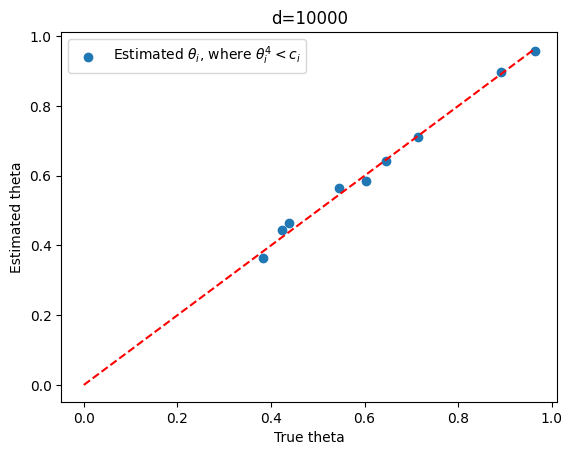

In [ ]:
############ Plotting and saving
print(theta_arr)
print(theta_est)

plt.scatter(theta_arr[1:],theta_est[1:], label=r'Estimated $\theta_i$, where $\theta_i^4 < c_i$')
max_val = max(theta_arr[1:].max(),theta_est[1:].max())
plt.plot([0,max_val],[0,max_val],color='red', linestyle='--')
plt.xlabel('True theta')
plt.ylabel('Estimated theta')
plt.title(f'd={d}')
plt.legend()


# ###### saving
# plt.savefig('sim_results/theta_estimation.pdf')
# ###### save results as tsv. For each table 1,...,M record theta_i, c_i, theta_est_i
# df = pd.DataFrame({'theta_true':theta_arr,'c':c_arr,'theta_est':theta_est})
# df.to_csv('sim_results/theta_estimation.tsv',sep='\t',index=False)

## Suboptimality of binary svdstack

In [ ]:

###### version 1 with constant c
def construct_c_theta_v1(M):
    synthetic_c = np.ones(M)
    synthetic_theta = np.sqrt(np.array([np.sqrt(x) - np.sqrt(x-1) for x in range(1,M+1)]))
    return synthetic_theta,synthetic_c

###### version 2 with constant theta
def construct_c_theta_v2(M):
    synthetic_theta = np.ones(M)
    synthetic_c = np.array([x**2 - (x-1)**2 for x in range(1,M+1)])
    return synthetic_theta,synthetic_c

In [ ]:
M_max=100000
M_arr = np.logspace(np.log10(2),np.log10(M_max),30).astype(int)
arrs_v2 = [construct_c_theta_v2(M) for M in M_arr]
powers_v2 = []
for arr in tqdm(arrs_v2):
    powers_v2.append(compute_asymptotic_power(1,arr[0],arr[1]))
    
powers_v2 = np.array(powers_v2)


100%|██████████| 30/30 [00:04<00:00,  6.66it/s] 


In [31]:
import numpy as np
from scipy.special import digamma, polygamma
from scipy.optimize  import newton

def inv_digamma(y, tol=1e-8, maxiter=50):
    """
    Inverse of the digamma function ψ(x) = y via Newton’s method.

    Solves ψ(x) - y = 0 by Newton–Raphson.
    """
    # Euler–Mascheroni constant
    gamma = float(mpmath.euler)

    # Initial guess (Minka, 2000)
    if y >= -2.22:
        x0 = np.exp(y) + 0.5
    else:
        x0 = -1.0 / (y + gamma)

    f      = lambda x: digamma(x) - y
    fprime = lambda x: polygamma(1, x)

    # Correct Newton call with keyword args:
    return newton(f, x0, fprime=fprime, tol=tol, maxiter=maxiter)


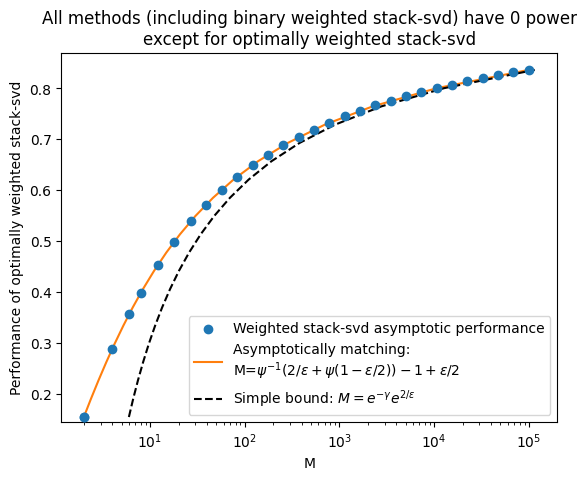

In [44]:
# Plotting the asymptotic performance of optimally weighted stack-svd


# Euler–Mascheroni constant
gamma = float(mpmath.euler)

# Plot weighted stack-svd asymptotic performance
color_next = plt.gca()._get_lines.get_next_color()
plt.scatter(M_arr, powers_v2, label='Weighted stack-svd asymptotic performance', color=color_next, zorder=10)

# Compute and plot theoretical prediction curve
eps_to_est_at = np.linspace(1 - powers_v2[0], 1 - powers_v2[-1], 20)
M_at_eps = []
for eps in eps_to_est_at:
    # Theoretical prediction for M as a function of epsilon
    M_at_eps.append(inv_digamma(2 / eps + scipy.special.digamma(1 - eps / 2)) - 1 + eps / 2)
color = plt.gca()._get_lines.get_next_color()
plt.plot(M_at_eps, 1 - eps_to_est_at, color=color, linestyle='-', 
         label='Asymptotically matching:\n'+r'M=$\psi^{-1}(2/\epsilon + \psi(1-\epsilon/2)) - 1 + \epsilon/2$')

plt.xscale('log')
plt.xlabel('M')
plt.ylabel('Performance of optimally weighted stack-svd')
plt.title('All methods (including binary weighted stack-svd) have 0 power\nexcept for optimally weighted stack-svd')

# Simple bound curve
M_at_eps = np.exp(-gamma) * np.exp(2/eps_to_est_at)
plt.plot(M_at_eps, 1 - eps_to_est_at, label=r'Simple bound: $M = e^{-\gamma} e^{2/\epsilon}$', linestyle='--', color='black')

plt.ylim(bottom=powers_v2[0] - .01)  # Set a lower limit for the y-axis to avoid cluttering
plt.legend()





# df_power = pd.DataFrame({'M': M_arr, 'stack_svd_power': powers_v2})
# df_pred = pd.DataFrame({'M': M_at_eps, 'power_predicted': 1-eps_to_est_at})
# df_merge = pd.merge(df_power, df_pred, on='M', how='outer')
# df_merge.to_csv('sim_results/binary_weighting_results.tsv', sep='\t', index=False)

plt.savefig('sim_results/binary_stack_svd_power.pdf')
